In [17]:
import palaestrai
import palaestrai.core
import palaestrai.store
import palaestrai.store.database_util
import palaestrai.store.database_model as paldb

import sqlalchemy as sa

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
import jsonpickle
import jsonpickle.ext.numpy as jsonpickle_numpy
jsonpickle_numpy.register_handlers()

In [20]:
import io
import os
import pprint
import tempfile
from pathlib import Path

In [21]:
# Experiment Run Meta Data
from datetime import datetime


EID = "20220823-carl1-erikas-reward-v1"
META_DATA = (
    "# Classic ARL\n\n"
    "* Single Phase\n"
    "* DDPG Attacker\n"
    "* PPO defender\n"
    "* 250 simulation steps\n"
    "* training only\n"
)
PLOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "results", EID))
os.makedirs(PLOT_PATH, exist_ok=True)
REWARD_VOLTAGE = os.path.join(PLOT_PATH, "reward_voltage.png")
REWARD_LOADING = os.path.join(PLOT_PATH, "reward_loading.png")

with open(os.path.join(PLOT_PATH, "metadata.md"), "w") as f:
    f.write(META_DATA)
    f.write("\n\n*Created at ")
    f.write(datetime.now().strftime("%H:%M:%S%z, %Y-%m-%d"))
    f.write("*\n")

EXP_RUN_NAME = "Classic ARL single phase with PPO and DDPG"
ERI_IDX = -1

In [22]:
rtc = palaestrai.core.RuntimeConfig()

In [23]:
store_uri = f"sqlite:///{os.path.abspath(os.path.join(os.getcwd(), '..', 'palaestrai.db'))}"
rtc.__dict__["_store_uri"] = store_uri
store_uri

'sqlite:////home/sbalduin/work/arl-experiments/classic-arl/palaestrai.db'

In [24]:
rtc.store_uri

'sqlite:////home/sbalduin/work/arl-experiments/classic-arl/palaestrai.db'

In [25]:
dbh = palaestrai.store.Session()

In [26]:
q = sa.select(paldb.ExperimentRun).where(paldb.ExperimentRun.uid == EXP_RUN_NAME)
str(q)


'SELECT experiment_runs.document, experiment_runs.document_json, experiment_runs.id, experiment_runs.uid, experiment_runs.experiment_id \nFROM experiment_runs \nWHERE experiment_runs.uid = :uid_1'

In [27]:
result = dbh.execute(q).one()
experiment_run_record = result[paldb.ExperimentRun]
experiment_run_record.id, experiment_run_record.uid

(2, 'Classic ARL single phase with PPO and DDPG')

In [28]:
experiment_run_record.experiment_run_instances

In [29]:
experiment_run_record.experiment_run_instances[ERI_IDX].experiment_run_phases

In [30]:
pd.read_sql(
    sa.select(paldb.Agent)
    .where(
        paldb.Agent.experiment_run_phase_id.in_(
            phase.id for phase in experiment_run_record.experiment_run_instances[ERI_IDX].experiment_run_phases
        )
    ),
    dbh.bind
)

id      uid     name                                            muscles  \
0  20  gandalf  gandalf  [Classic ARL single phase with PPO and DDPG_A:...   
1  21   sauron   sauron  [Classic ARL single phase with PPO and DDPG_A:...   

                                       configuration  experiment_run_phase_id  
0  {'name': 'gandalf', 'brain': {'name': 'harl.dd...                       16  
1  {'name': 'sauron', 'brain': {'name': 'harl.ppo...                       16

In [31]:
run_phase_id = min(phase.id for phase in experiment_run_record.experiment_run_instances[ERI_IDX].experiment_run_phases)
run_phase_id

16

In [32]:
agent_record = dbh.execute(
    sa.select(paldb.Agent)
    .where(paldb.Agent.experiment_run_phase_id==run_phase_id)
    .where(paldb.Agent.name=="gandalf")
).one()[paldb.Agent]
agent_record.id, agent_record.name

(20, 'gandalf')

In [33]:
actions = pd.read_sql(
    sa.select(paldb.MuscleAction).where(paldb.MuscleAction.agent_id==agent_record.id),
    dbh.bind
)
actions

id                   walltime  agent_id  \
0     915 2022-08-23 12:38:40.081687        20   
1     917 2022-08-23 12:38:44.412823        20   
2     919 2022-08-23 12:38:45.691077        20   
3     921 2022-08-23 12:38:46.880509        20   
4     923 2022-08-23 12:38:47.862040        20   
..    ...                        ...       ...   
244  1403 2022-08-23 12:44:58.978111        20   
245  1405 2022-08-23 12:45:00.734441        20   
246  1407 2022-08-23 12:45:02.195594        20   
247  1409 2022-08-23 12:45:03.982097        20   
248  1411 2022-08-23 12:45:06.226127        20   

                                              simtimes  \
0    {'env': {'py/object': 'palaestrai.types.simtim...   
1    {'env': {'py/object': 'palaestrai.types.simtim...   
2    {'env': {'py/object': 'palaestrai.types.simtim...   
3    {'env': {'py/object': 'palaestrai.types.simtim...   
4    {'env': {'py/object': 'palaestrai.types.simtim...   
..                                                 ...   
244  {'env': {'py/object': 'palaestrai.types.simtim...   
245  {'env': {'py/object': 'palaestrai.types.simtim...   
246  {'env': {'py/object': 'palaestrai.types.simtim...   
247  {'env': {'py/object': 'palaestrai.types.simtim...   
248  {'env': {'py/object': 'palaestrai.types.simtim...   

                                       sensor_readings  \
0    [{'py/object': 'palaestrai.agent.sensor_inform...   
1    [{'py/object': 'palaestrai.agent.sensor_inform...   
2    [{'py/object': 'palaestrai.agent.sensor_inform...   
3    [{'py/object': 'palaestrai.agent.sensor_inform...   
4    [{'py/object': 'palaestrai.agent.sensor_inform...   
..                                                 ...   
244  [{'py/object': 'palaestrai.agent.sensor_inform...   
245  [{'py/object': 'palaestrai.agent.sensor_inform...   
246  [{'py/object': 'palaestrai.agent.sensor_inform...   
247  [{'py/object': 'palaestrai.agent.sensor_inform...   
248  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                    actuator_setpoints  \
0    [{'py/object': 'palaestrai.agent.actuator_info...   
1    [{'py/object': 'palaestrai.agent.actuator_info...   
2    [{'py/object': 'palaestrai.agent.actuator_info...   
3    [{'py/object': 'palaestrai.agent.actuator_info...   
4    [{'py/object': 'palaestrai.agent.actuator_info...   
..                                                 ...   
244  [{'py/object': 'palaestrai.agent.actuator_info...   
245  [{'py/object': 'palaestrai.agent.actuator_info...   
246  [{'py/object': 'palaestrai.agent.actuator_info...   
247  [{'py/object': 'palaestrai.agent.actuator_info...   
248  [{'py/object': 'palaestrai.agent.actuator_info...   

                                               rewards  
0    [{'py/object': 'palaestrai.agent.reward_inform...  
1    [{'py/object': 'palaestrai.agent.reward_inform...  
2    [{'py/object': 'palaestrai.agent.reward_inform...  
3    [{'py/object': 'palaestrai.agent.reward_inform...  
4    [{'py/object': 'palaestrai.agent.reward_inform...  
..                                                 ...  
244  [{'py/object': 'palaestrai.agent.reward_inform...  
245  [{'py/object': 'palaestrai.agent.reward_inform...  
246  [{'py/object': 'palaestrai.agent.reward_inform...  
247  [{'py/object': 'palaestrai.agent.reward_inform...  
248  [{'py/object': 'palaestrai.agent.reward_inform...  

[249 rows x 7 columns]

In [34]:
len(actions.rewards[0])

11

In [35]:
def unpack_reward(x, i):
    try:
        val = x[i]["reward_value"]["value"]
    except KeyError as err:
        try:
            val = x[i]["reward_value"]["values"][0]
        except KeyError as err:
            print(f"Error at index {i}: {err}")
            print(x[i])
            raise err
    return float(val) if x else 0.0

cols = ["vm_pu_min", "vm_pu_max", "vm_pu_median", "vm_pu_mean", "vm_pu_std", "line_min", "line_max", "line_median", "line_mean", "line_std"]

for idx, name in enumerate(cols):
    actions[name] = actions.rewards.apply(lambda x: unpack_reward(x, idx))

actions




id                   walltime  agent_id  \
0     915 2022-08-23 12:38:40.081687        20   
1     917 2022-08-23 12:38:44.412823        20   
2     919 2022-08-23 12:38:45.691077        20   
3     921 2022-08-23 12:38:46.880509        20   
4     923 2022-08-23 12:38:47.862040        20   
..    ...                        ...       ...   
244  1403 2022-08-23 12:44:58.978111        20   
245  1405 2022-08-23 12:45:00.734441        20   
246  1407 2022-08-23 12:45:02.195594        20   
247  1409 2022-08-23 12:45:03.982097        20   
248  1411 2022-08-23 12:45:06.226127        20   

                                              simtimes  \
0    {'env': {'py/object': 'palaestrai.types.simtim...   
1    {'env': {'py/object': 'palaestrai.types.simtim...   
2    {'env': {'py/object': 'palaestrai.types.simtim...   
3    {'env': {'py/object': 'palaestrai.types.simtim...   
4    {'env': {'py/object': 'palaestrai.types.simtim...   
..                                                 ...   
244  {'env': {'py/object': 'palaestrai.types.simtim...   
245  {'env': {'py/object': 'palaestrai.types.simtim...   
246  {'env': {'py/object': 'palaestrai.types.simtim...   
247  {'env': {'py/object': 'palaestrai.types.simtim...   
248  {'env': {'py/object': 'palaestrai.types.simtim...   

                                       sensor_readings  \
0    [{'py/object': 'palaestrai.agent.sensor_inform...   
1    [{'py/object': 'palaestrai.agent.sensor_inform...   
2    [{'py/object': 'palaestrai.agent.sensor_inform...   
3    [{'py/object': 'palaestrai.agent.sensor_inform...   
4    [{'py/object': 'palaestrai.agent.sensor_inform...   
..                                                 ...   
244  [{'py/object': 'palaestrai.agent.sensor_inform...   
245  [{'py/object': 'palaestrai.agent.sensor_inform...   
246  [{'py/object': 'palaestrai.agent.sensor_inform...   
247  [{'py/object': 'palaestrai.agent.sensor_inform...   
248  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                    actuator_setpoints  \
0    [{'py/object': 'palaestrai.agent.actuator_info...   
1    [{'py/object': 'palaestrai.agent.actuator_info...   
2    [{'py/object': 'palaestrai.agent.actuator_info...   
3    [{'py/object': 'palaestrai.agent.actuator_info...   
4    [{'py/object': 'palaestrai.agent.actuator_info...   
..                                                 ...   
244  [{'py/object': 'palaestrai.agent.actuator_info...   
245  [{'py/object': 'palaestrai.agent.actuator_info...   
246  [{'py/object': 'palaestrai.agent.actuator_info...   
247  [{'py/object': 'palaestrai.agent.actuator_info...   
248  [{'py/object': 'palaestrai.agent.actuator_info...   

                                               rewards  vm_pu_min  vm_pu_max  \
0    [{'py/object': 'palaestrai.agent.reward_inform...   1.001121   1.028082   
1    [{'py/object': 'palaestrai.agent.reward_inform...   1.000893   1.030033   
2    [{'py/object': 'palaestrai.agent.reward_inform...   1.001630   1.026521   
3    [{'py/object': 'palaestrai.agent.reward_inform...   1.004213   1.028689   
4    [{'py/object': 'palaestrai.agent.reward_inform...   1.004237   1.028016   
..                                                 ...        ...        ...   
244  [{'py/object': 'palaestrai.agent.reward_inform...   0.930593   0.968038   
245  [{'py/object': 'palaestrai.agent.reward_inform...   0.936800   0.965631   
246  [{'py/object': 'palaestrai.agent.reward_inform...   0.936424   0.968679   
247  [{'py/object': 'palaestrai.agent.reward_inform...   0.000000   0.964082   
248  [{'py/object': 'palaestrai.agent.reward_inform...   0.000000   0.964082   

     vm_pu_median  vm_pu_mean  vm_pu_std  line_min   line_max  line_median  \
0        1.027927    1.023096   0.009009  0.037608  28.364276     0.909739   
1        1.029877    1.024628   0.009792  0.037600  28.874269     0.911465   
2        1.026366    1.021952   0.008224  0.037628  27.947752     0.908358   
3        1.028534    1.024216   0.008061  

In [36]:
actions["vm_pu_min_mean"] = actions["vm_pu_min"].rolling(20).mean()
actions["vm_pu_max_mean"] = actions["vm_pu_max"].rolling(20).mean()
actions["vm_pu_mean_mean"] = actions["vm_pu_mean"].rolling(20).mean()
actions["vm_pu_median_mean"] = actions["vm_pu_median"].rolling(20).mean()
index = np.arange(len(actions.id))


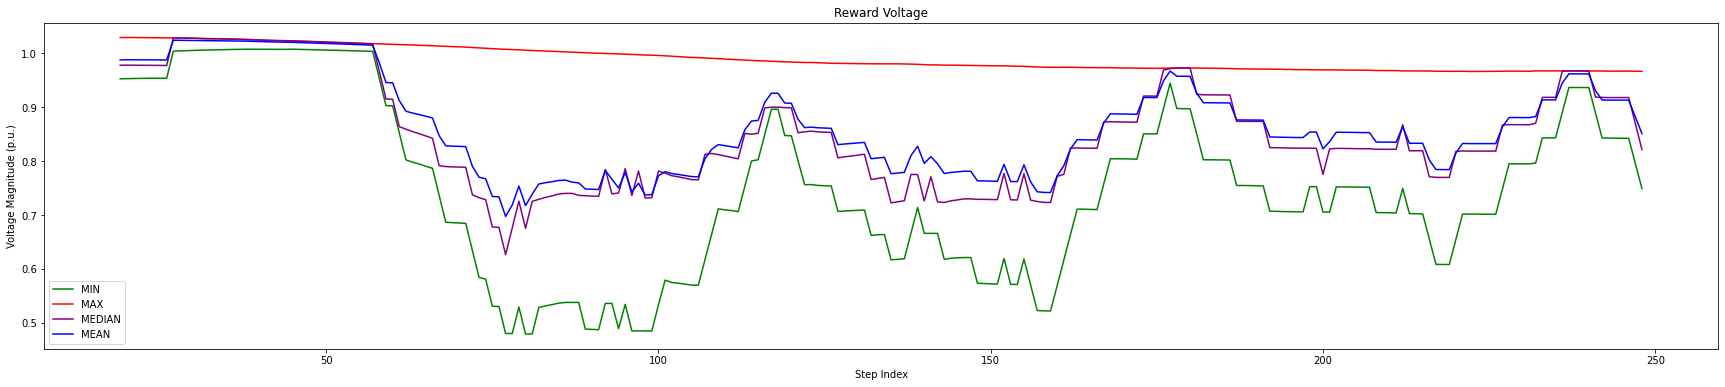

In [37]:
plt.figure(figsize=(30, 6))
plt.plot(index, actions.vm_pu_min_mean, color="green", label="MIN")
plt.plot(index, actions.vm_pu_max_mean, color="red", label="MAX")
plt.plot(index, actions.vm_pu_median_mean, color="purple", label="MEDIAN")
plt.plot(index, actions.vm_pu_mean_mean, color="blue", label="MEAN")
plt.xlabel("Step Index")
plt.ylabel("Voltage Magnitude (p.u.)")
plt.title("Reward Voltage")
plt.legend()

plt.savefig(REWARD_VOLTAGE, bbox_inches="tight", dpi=300)


In [38]:
actions["line_min_mean"] = actions["line_min"].rolling(20).mean()
actions["line_max_mean"] = actions["line_max"].rolling(20).mean()
actions["line_mean_mean"] = actions["line_mean"].rolling(20).mean()
actions["line_median_mean"] = actions["line_median"].rolling(20).mean()

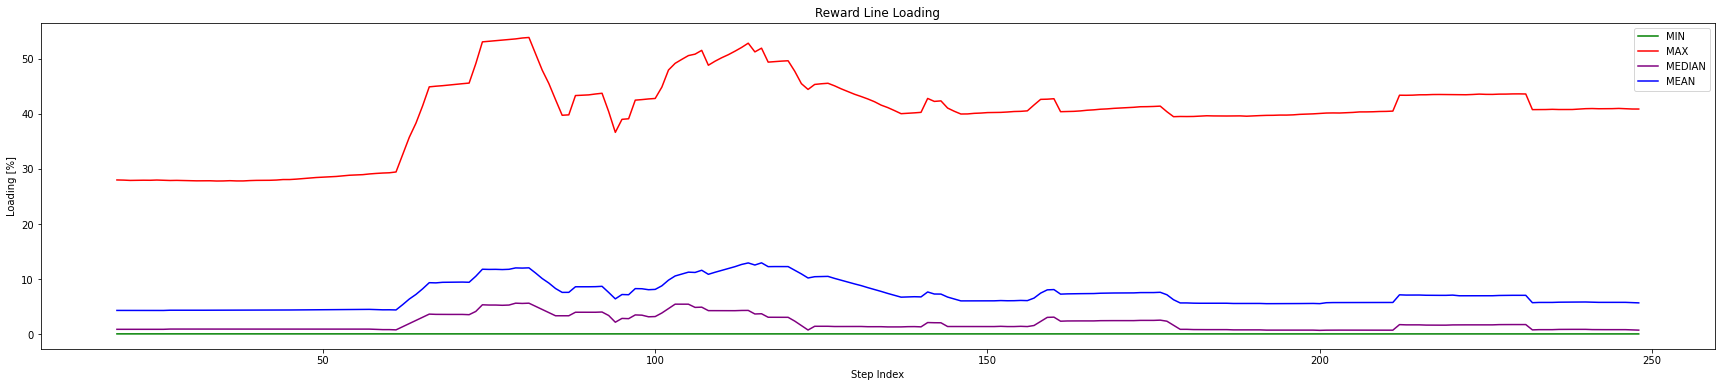

In [39]:
plt.figure(figsize=(30, 6))
plt.plot(index, actions.line_min_mean, color="green", label="MIN")
plt.plot(index, actions.line_max_mean, color="red", label="MAX")
plt.plot(index, actions.line_median_mean, color="purple", label="MEDIAN")
plt.plot(index, actions.line_mean_mean, color="blue", label="MEAN")
plt.xlabel("Step Index")
plt.ylabel("Loading [%]")
plt.title("Reward Line Loading")
plt.legend()

plt.savefig(REWARD_LOADING, bbox_inches="tight", dpi=300)

In [40]:
actions.line_max_mean

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
244    40.951587
245    40.992016
246    40.948602
247    40.887509
248    40.882236
Name: line_max_mean, Length: 249, dtype: float64